## setup

In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

#import packages
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import subprocess
from datetime import datetime


#local imports from opensoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
from opensoundscape.ribbit import ribbit

# create big visuals
plt.rcParams['figure.figsize']=[15,8]
pd.set_option('display.precision', 2)

## read in RIBBIT scores and basic cleaning 

In [160]:
# folder with ribbit scores of interest
ribbit_folder = "ribbit_scores_2022_01_21"

#creates list of all cdv ribbit files to concatonate into one df of all ribbit scores
all_files = glob(ribbit_folder + "/*.csv")
ribbit_list = []

# reads in all ribbit scores to csv 
for filename in all_files: 
    df = pd.read_csv("./" + filename)
    ribbit_list.append(df)

rs_df = pd.DataFrame()
rs_df = pd.concat(ribbit_list, axis=0, ignore_index=True) # translates list into dataframe 

rs_df = rs_df.rename(columns={"Unnamed: 0" : "file_path"})

# use file_path to create column with date and time of file 
rs_df['date'] = pd.to_datetime(rs_df.file_path.str[-19:-4], format='%Y%m%d_%H%M%S', errors='coerce')

# add in manually determined files
tr_df = pd.read_csv("./training_data.csv")
rs_df = pd.merge(rs_df, tr_df, on=['pond', 'file_path'], how = "left")
rs_df = rs_df[rs_df.duplicated(subset=None, keep='first')] # remove duplicates #TODO: why duplicates? file with all scores? 

# todo: add that if file starts with "Lcapito", Lcapito = 1

## plotting ribbit scores

In [162]:
def plot_rs(pond_no = "all", year = "all"):
    
    plot_data = rs_df

    if pond_no != "all":
        plot_data = plot_data[plot_data['pond'] == pond_no]

    if year != "all":
        plot_data = plot_data[plot_data['year'] == year]

        
    
    fig, ax = plt.subplots()  # a figure with a single Axes
    ax.scatter(plot_data['date'],plot_data['score'])
    ax.hlines(y = [40], xmin = plot_data.date.min(), 
              xmax = plot_data.date.max(),
             colors = 'r', linestyles = '--')
    ax.set_xlabel('date')
    ax.set_ylabel('RIBBIT score') 
    ax.set_title('RIBBIT scores')
    #ax.set_ylim(0,400)
    
def plot_hist(pond_no = "all", year = "all"):
    
    plot_data = rs_df

    if pond_no != "all":
        plot_data = plot_data[plot_data['pond'] == pond_no]

    if year != "all":
        plot_data = plot_data[plot_data['year'] == year]

        
    
    fig, ax = plt.subplots()  # a figure with a single Axes
    ax.hist(plot_data['date'], bins = 12*12)
    ax.set_xlabel('date')
    ax.set_ylabel('Number of files') 
    ax.set_title('Histogram of data from pond ' + str(pond_no))
    #ax.set_ylim(0,400) 
    

# get list of audio files with top ribbit scores
#
# input: 
# rs_df - data frame with ribbit scores 
# ponds - list of ponds to get scores for 
# t_unit - unit for how often we want the top scores (options: day, week, month, year)
# NOT IMPLEMENTED!!! t_n - number for how foten we want the top scores 
# NOT IMPLEMENTED!!! start - if "first", start with the first file, else `start` should be a date 
# NOT IMPLEMENTED!!! end - if "last", end with the last file, else `start` should be a date 
# (e.g. if n = 5, ponds = range(398, 403), t_unit = week and t_n = 3, we want the top 5 scores for every three weeks for all of the ponds )
#
# out: 
# dataframe with top `n` files for `ponds` for every `t_n` `t_unit` beginning with `start` and finishing with `end`
def get_top_rs(rs_df, n = 5, ponds = range(398, 403), t_unit = "year", t_n = 1, start = "first", end = "last"):
    

    if t_unit == "month": 
        rs_df['date_group'] = rs_df['date'].dt.to_period('M') # create a column with the month the file was recorded
    
    elif t_unit == "week":     
        rs_df['date_group'] = rs_df['date'].dt.to_period('W') # create a column with the week of the month the file was recorded
    
    elif t_unit == "day":
        rs_df['date_group'] = rs_df['date'].dt.to_period('D') # create a column with the day of the month the file was recorded

    else: 
        rs_df['date_group'] = rs_df['date'].dt.to_period('Y') # create a column with the year the file was recorded
    
    out_df = rs_df.sort_values(by='score',ascending=False).groupby(by = ['pond', 'date_group']).head(n).sort_values(by = ['pond', 'year', 'date_group'])

    
    # organize the df
    out_df['file_path'] = out_df['file_path'].str.slice(61) # simplify file path to not have beginning crap
    out_df = out_df.reindex(columns = ['Lcapito', 'pond', 'date_group', 'score', 'time_stamp', 'file_path']) #order columns 
   
    return out_df




In [164]:
test = get_top_rs(rs_df, n=2, t_unit = 'year')
test.head(20)
test.to_csv("test_organized_scores.csv") 


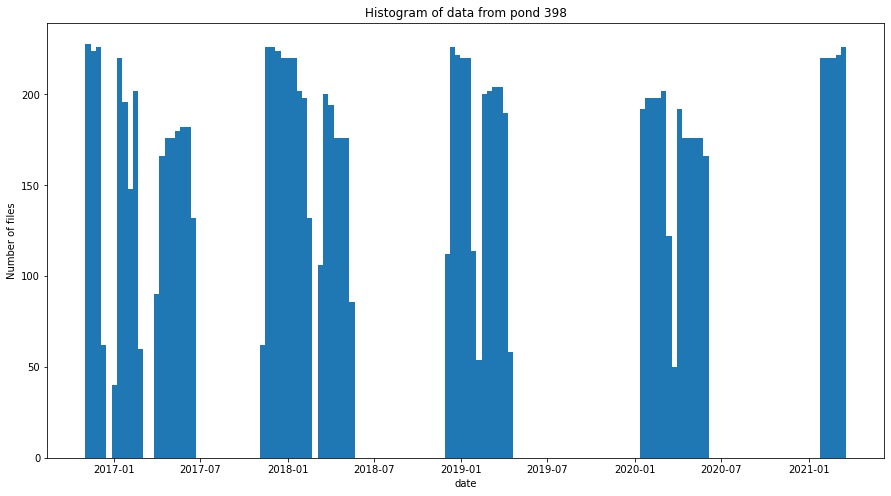

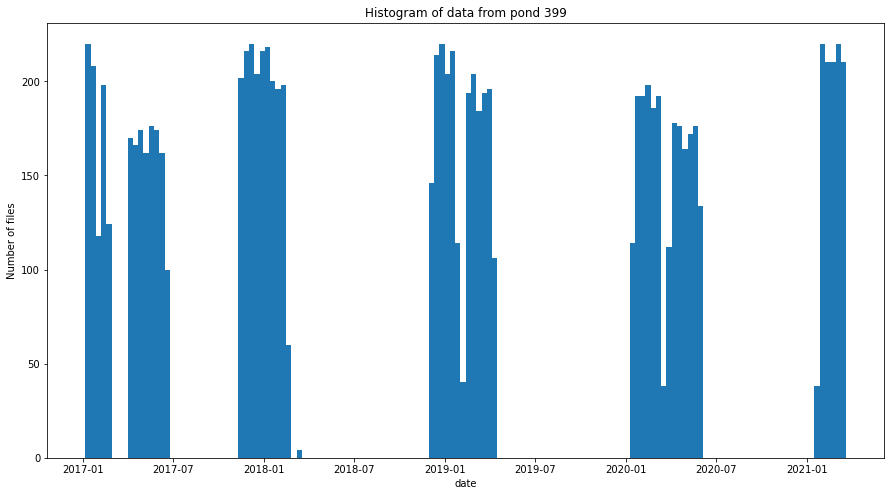

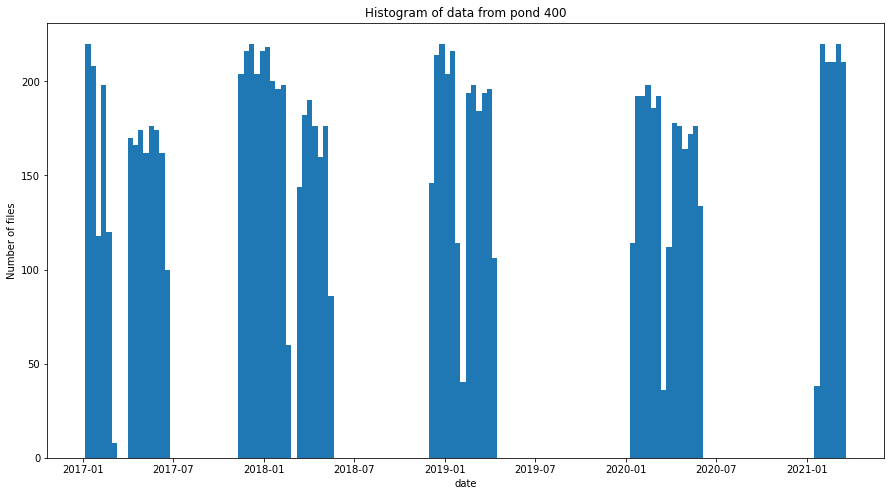

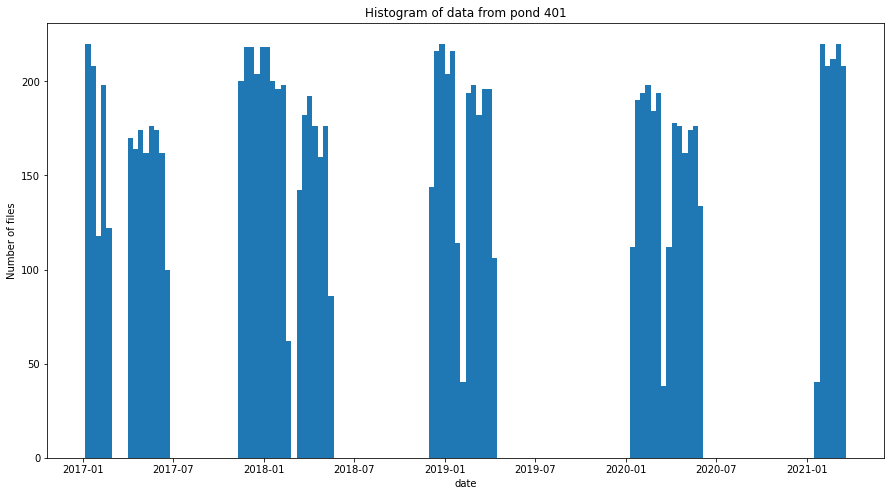

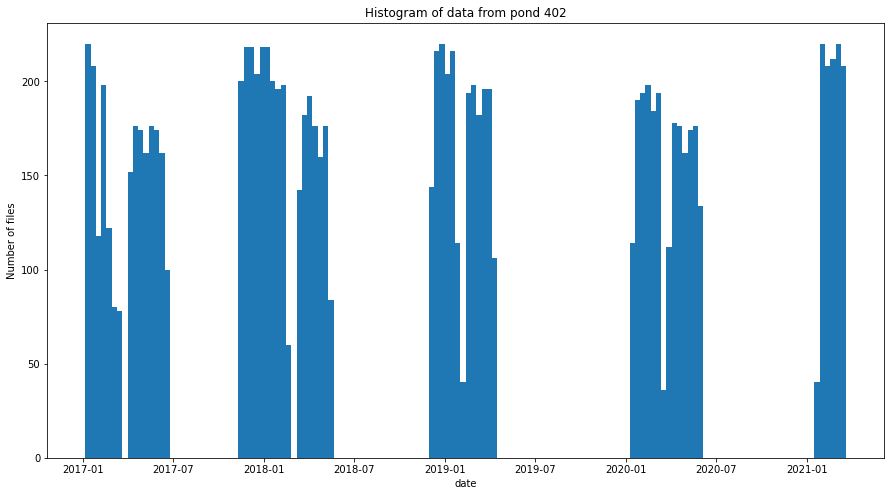

In [13]:
#pd.set_option('display.max_colwidth', -1) 
#rs_df[rs_df["pond"] == 398][rs_df["year"] == 2017]

#for yr in range(2017,2022):
#    plot_rs(pond_no = 401, year = yr)

for pond in range(398, 403): 
    plot_hist(pond_no = pond)


In [264]:
rs_df[rs_df["pond"] == 398][rs_df[rs_df["pond"] == 398]['score'] > 40]

,file_path,score,year,pond,time_stamp,date,Lcapito
1113,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180508_222300.wav,60.22,2018,398,232.0,2018-05-08 22:23:00,NaN
1114,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180511_012500.wav,57.53,2018,398,44.0,2018-05-11 01:25:00,NaN
1115,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180318_234700.wav,55.39,2018,398,138.0,2018-03-18 23:47:00,NaN
1116,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180121_190000.wav,52.94,2018,398,40.0,2018-01-21 19:00:00,NaN
1117,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2018/FLSHE_2018_398/TEST_0+1_20180116_195500.wav,52.62,2018,398,6.0,2018-01-16 19:55:00,NaN
...,...,...,...,...,...,...,...
6581,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20170111_205100.wav,40.08,2017,398,174.0,2017-01-11 20:51:00,NaN
6582,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20161129_183100.wav,40.07,2017,398,284.0,2016-11-29 18:31:00,NaN
6583,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20170414_230600.wav,40.03,2017,398,182.0,2017-04-14 23:06:00,NaN
6584,/Volumes/Expansion/Frog Call Project/Calling Data/Frog Calls/FLSHE_2017/FLSHE_2017_398/TEST_0+1_20171215_003300.wav,40.01,2017,398,44.0,2017-12-15 00:33:00,NaN
